In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from io import StringIO

def convert_value_string(value_str):
    """Convert a value string like '£18.5M' or '£300K' to numeric"""
    if pd.isna(value_str) or value_str == '' or value_str == 'Not for Sale':
        return np.nan
    
    cleaned = str(value_str).replace('£', '').replace(',', '').strip()
    
    try:
        if 'M' in cleaned:
            number = float(cleaned.replace('M', '')) * 1_000_000
        elif 'K' in cleaned:
            number = float(cleaned.replace('K', '')) * 1_000
        else:
            number = float(cleaned)
        return number
    except (ValueError, AttributeError):
        return np.nan

def prepare_html_data(file_path, is_my_squad=False):
    """
    Read and preprocess Football Manager HTML data file into a pandas DataFrame
    
    Parameters:
    file_path (str): Path to the HTML file
    is_my_squad (bool): If True, uses more conservative valuation (closer to min value)
    
    Returns:
    pandas.DataFrame: Preprocessed DataFrame with cleaned attributes and encoded positions
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    df = pd.read_html(StringIO(html_content))[0]
    
    df.columns = df.columns.str.strip()
    df = df.replace(r'^\s*$', pd.NA, regex=True)
    
    if 'Wage' in df.columns:
        df['Wage'] = df['Wage'].str.replace('£', '').str.replace(' p/w', '').str.replace(',', '')
        df['Wage'] = pd.to_numeric(df['Wage'], errors='coerce')
    
    numeric_columns = ['Age', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer', 'Agg', 'Agi', 'Ant', 
                      'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec', 'Det', 'Dri', 'Fin',
                      'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr', 'Lon', 'Mar', 'OtB',
                      'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 'Thr',
                      'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # First, let's modify the position_features dictionary:
    position_features = {
        "is_gk": r"GK",
        "is_dc": r"D \((?:C|LC|RC|RLC)\)",
        "is_lcb": None,  # Will handle separately due to complex condition
        "is_rcb": None,  # Will handle separately due to complex condition
        "is_lb": r"D \(L\)$|WB \(L\)$|LWB$",
        "is_rb": r"D \(R\)$|WB \(R\)$|RWB$",
        "is_dm": r"DM",
        "is_mc": r"M \([LR]*C[LR]*\)",
        "is_amc": r"AM \(C\)",
        "is_aml": r"AM \(L\)|M\/AM \(L\)",
        "is_amr": r"AM \(R\)|M\/AM \(R\)",
        "is_st": r"ST|ST \([LRC]\)"
    }

    # Then modify the position assignment section in prepare_html_data:
    df["Position"] = df["Position"].fillna("")
    df["Left Foot"] = df["Left Foot"].fillna("")
    df["Right Foot"] = df["Right Foot"].fillna("")

    # First handle the regular position features
    for feature, pattern in position_features.items():
        if pattern is not None:  # Skip lcb and rcb as they need special handling
            df[feature] = df["Position"].str.contains(pattern, regex=True).astype(int)

    # Special handling for LCB and RCB
    # LCB: Must be able to play DC and have strong left foot
    df['is_lcb'] = ((df["Position"].str.contains(r"D \((?:C|LC|RC|RLC)\)", regex=True)) & 
                    (df["Left Foot"].str.contains("Strong", case=False, na=False))).astype(int)

    # RCB: Must be able to play DC and have strong right foot
    df['is_rcb'] = ((df["Position"].str.contains(r"D \((?:C|LC|RC|RLC)\)", regex=True)) & 
                    (df["Right Foot"].str.contains("Strong", case=False, na=False))).astype(int)
    
    if 'Transfer Value' in df.columns:
        
        df['Transfer Value'] = df['Transfer Value'].fillna('')
    
        has_range = df['Transfer Value'].str.contains(' - ', na=False)
        
        range_df = df[has_range].copy()
        if not range_df.empty:
            range_df[['Min Value', 'Max Value']] = range_df['Transfer Value'].str.split(' - ', expand=True)
            range_df['Min Value'] = range_df['Min Value'].apply(convert_value_string)
            range_df['Max Value'] = range_df['Max Value'].apply(convert_value_string)
            # Use conservative upper range of value for incoming players
            range_df['Avg Value'] = range_df['Min Value'] + (range_df['Max Value'] - range_df['Min Value']) * 0.9
        
        single_df = df[~has_range].copy()
        if not single_df.empty:
            single_df['Avg Value'] = single_df['Transfer Value'].apply(convert_value_string)
            single_df['Min Value'] = single_df['Avg Value']
            single_df['Max Value'] = single_df['Avg Value']
        
        if not range_df.empty:
            df.loc[range_df.index, ['Min Value', 'Max Value', 'Avg Value']] = range_df[['Min Value', 'Max Value', 'Avg Value']]
        if not single_df.empty:
            df.loc[single_df.index, ['Min Value', 'Max Value', 'Avg Value']] = single_df[['Min Value', 'Max Value', 'Avg Value']]
            

    # Handle missing values using regression for transfer targets
    if not is_my_squad and 'Avg Value' in df.columns and df['Avg Value'].isna().any():
        feature_cols = [col for col in numeric_columns if col in df.columns]
        if 'Wage' in df.columns:
            feature_cols.append('Wage')
        
        # Add position dummy variables
        for pos in position_features.keys():
            if pos in df.columns:
                feature_cols.append(pos)
        
        # Remove rows with NaN in features
        features_df = df[feature_cols].copy()
        mask = ~features_df.isna().any(axis=1) & ~df['Avg Value'].isna()
        
        if mask.sum() >= 5:  # Only use regression if we have enough complete samples
            X = features_df.loc[mask]
            y = df.loc[mask, 'Avg Value']
            
            # Fit regression model
            model = LinearRegression()
            model.fit(X, y)
            
            r2_score = model.score(X, y)
            
            missing_mask = df['Avg Value'].isna() & ~features_df.isna().any(axis=1)
            if missing_mask.any():
                X_missing = features_df.loc[missing_mask]
                predicted_values = model.predict(X_missing)
                df.loc[missing_mask, 'Avg Value'] = predicted_values
    
    remaining_nans = df['Avg Value'].isna().sum()
    if remaining_nans > 0:
        for pos in position_features.keys():
            pos_mask = (df[pos] == 1) & (df['Avg Value'].isna())
            if pos_mask.any():
                median_value = df.loc[(df[pos] == 1) & (~df['Avg Value'].isna()), 'Avg Value'].median()
                if pd.isna(median_value):  
                    median_value = df['Avg Value'].median()  
                if pd.isna(median_value):  
                    median_value = 1000000  
                df.loc[pos_mask, 'Avg Value'] = median_value
    
    # Ensure no NaN or negative values in final output
    df['Avg Value'] = df['Avg Value'].fillna(1000000).clip(lower=0)
    df['Min Value'] = df['Min Value'].fillna(df['Avg Value']).clip(lower=0)
    df['Max Value'] = df['Max Value'].fillna(df['Avg Value']).clip(lower=0)

    if 'Av Rat' in df.columns:
        df['Av Rat'] = pd.to_numeric(df['Av Rat'].astype(str).str.replace(',', '.'), errors='coerce')
    
    return df

df = prepare_html_data(r"C:\Users\Owner\dev\football-analytics\optimisation\5-player-position-scouting-fm24\all_players.html")

df.head()



Debug Transfer Values:
0    £12M - £18.5M
1       £9M - £11M
2     £70M - £108M
3     Not for Sale
4     Not for Sale
Name: Transfer Value, dtype: object
Estimated 799 missing values using regression


,Inf,Name,Position,Nat,Age,Club,Wage,Transfer Value,Personality,Left Foot,...,is_mc,is_amc,is_aml,is_amr,is_st,is_lcb,is_rcb,Min Value,Max Value,Avg Value
0,NaN,Cristiano Ronaldo,ST (C),POR,39,Al-Nassr (KSA),3400000,£12M - £18.5M,Perfectionist,Strong,...,0,0,0,0,1,0,0,1.200000e+07,1.850000e+07,1.785000e+07
1,NaN,Karim Benzema,ST (C),FRA,36,Al-Ittihad,3300000,£9M - £11M,Model Professional,Fairly Strong,...,0,0,0,0,1,0,0,9.000000e+06,1.100000e+07,1.080000e+07
2,NaN,Neymar,"AM (LC), ST (C)",BRA,32,Al-Hilal (KSA),2500000,£70M - £108M,Fairly Determined,Fairly Strong,...,1,0,0,0,1,0,0,7.000000e+07,1.080000e+08,1.042000e+08
3,NaN,Sadio Mané,"AM (RLC), ST (C)",SEN,32,Al-Nassr (KSA),675000,Not for Sale,Perfectionist,Reasonable,...,1,0,0,0,1,0,0,6.914843e+07,6.914843e+07,6.914843e+07
4,NaN,Marcelo Brozović,"DM, M (C)",CRO,31,Al-Nassr (KSA),600000,Not for Sale,Resilient,Reasonable,...,1,0,0,0,0,0,0,6.464210e+07,6.464210e+07,6.464210e+07


In [4]:
class PlayerAttributeWeights:
    """Define position-specific and DNA attribute weights"""
    
    @staticmethod
    def dna_weights():
        return {
            'Agg': .25, 'Bra': .25, 'Det': .25, 'Wor': .25
        }

    @staticmethod
    def gk_weights():
        return {
            'Ref': 0.09, 'Pos': 0.09, '1v1': 0.08, 'Com': 0.08,
            'TRO': 0.07, 'Kic': 0.07, 'Agi': 0.07, 'Ant': 0.07,
            'Cmp': 0.07, 'Cnt': 0.07, 'Aer': 0.07, 'Fir': 0.06,
            'Han': 0.05, 'Pas': 0.04, 'Thr': 0.04
        }
    
    @staticmethod
    def ccb_weights():
        return {
            'Str': 0.0417, 'Jum': 0.0417, 'Cmp': 0.0417, 'Bra': 0.0417,
            'Pac': 0.0833, 'Mar': 0.0833, 'Tck': 0.0833, 'Hea': 0.0833,
            'Ant': 0.125, 'Cnt': 0.125, 'Dec': 0.125, 'Pos': 0.125
        }

    @staticmethod
    def lcb_weights():
        return {
            'Pos': 0.1, 'Dec': 0.1, 'Pac': 0.1, 'Str': 0.1,
            'Jum': 0.075, 'Tck': 0.075, 'Mar': 0.075, 'Hea': 0.075,
            'Dri': 0.05, 'Pas': 0.05, 'Agi': 0.05, 'Cmp': 0.05,
            'Ant': 0.025, 'Cnt': 0.025, 'Fir': 0.025, 'Sta': 0.025
        }  
    
    @staticmethod
    def rcb_weights():
        return {
            'Pos': 0.1, 'Dec': 0.1, 'Pac': 0.1, 'Str': 0.1,
            'Jum': 0.075, 'Tck': 0.075, 'Mar': 0.075, 'Hea': 0.075,
            'Dri': 0.05, 'Pas': 0.05, 'Agi': 0.05, 'Cmp': 0.05,
            'Ant': 0.025, 'Cnt': 0.025, 'Fir': 0.025, 'Sta': 0.025
        }  
    
    @staticmethod
    def rb_weights():
        return {
            'Acc': 0.1, 'Sta': 0.1, 'Wor': 0.1, 'Tea': 0.1,
            'Cro': 0.075, 'Mar': 0.075, 'Tck': 0.075, 'Pos': 0.075,
            'Dri': 0.05, 'Ant': 0.05, 'Pac': 0.05, 'Agi': 0.05,
            'Pas': 0.025, 'OtB': 0.025, 'Dec': 0.025, 'Cnt': 0.025
        }

    @staticmethod
    def lb_weights():
        return {
            'Acc': 0.1, 'Sta': 0.1, 'Wor': 0.1, 'Tea': 0.1,
            'Cro': 0.075, 'Mar': 0.075, 'Tck': 0.075, 'Pos': 0.075,
            'Dri': 0.05, 'Ant': 0.05, 'Pac': 0.05, 'Agi': 0.05,
            'Pas': 0.025, 'OtB': 0.025, 'Dec': 0.025, 'Cnt': 0.025
        } 
    
    @staticmethod
    def dm_weights():
        return {
            'Pos': 0.125, 'Cnt': 0.125, 'Ant': 0.125, 'Fir': 0.125,
            'Tck': 0.0833, 'Dec': 0.0833, 'Tea': 0.0833, 'Cmp': 0.0833,
            'Wor': 0.0417, 'Mar': 0.0417, 'Pas': 0.0417, 'Str': 0.0417
        }
    
    @staticmethod
    def cm_weights():
        return {
            'Sta': 0.1, 'Wor': 0.1, 'Tea': 0.1, 'OtB': 0.1,
            'Pas': 0.1, 'Tck': 0.1, 'Bal': 0.075, 'Ant': 0.075,
            'Dec': 0.05, 'Cmp': 0.05, 'Acc': 0.05, 'Fir': 0.05,
            'Str': 0.025, 'Dri': 0.025, 'Pac': 0.025, 'Tec': 0.025
        }
    
    @staticmethod
    def am_weights():
        return {
            'Vis': 0.111, 'Pas': 0.111, 'Tec': 0.111, 'Fir': 0.111,
            'Cmp': 0.089, 'Dec': 0.089, 'OtB': 0.083, 'Tea': 0.083,
            'Dri': 0.056, 'Acc': 0.056, 'Agi': 0.056, 'Fla': 0.056,
            'Ant': 0.028
        }
    
    @staticmethod
    def ss_weights():
        return {
            'OtB': 0.1, 'Acc': 0.1, 'Cmp': 0.1, 'Ant': 0.1,           
            'Dri': 0.075, 'Fin': 0.075, 'Fir': 0.075, 'Wor': 0.075,   
            'Dec': 0.05, 'Pas': 0.05, 'Tec': 0.05, 'Pac': 0.05,       
            'Agi': 0.025, 'Bal': 0.025, 'Cnt': 0.025, 'Sta': 0.025    
        }
    
    @staticmethod
    def rw_weights():
        return {
            'Dri': 0.121, 'Acc': 0.121, 'Agi': 0.121, 'Tec': 0.121,           
            'Cro': 0.121, 'Fir': 0.091, 'Bal': 0.091, 'Pac': 0.091,          
            'Sta': 0.061, 'Pas': 0.061, 'OtB': 0.061, 'Wor': 0.061          
        }
    
    @staticmethod
    def lw_weights():
        return {
            'Dri': 0.121, 'Acc': 0.121, 'Agi': 0.121, 'Tec': 0.121,           
            'Cro': 0.121, 'Fir': 0.091, 'Bal': 0.091, 'Pac': 0.091,          
            'Sta': 0.061, 'Pas': 0.061, 'OtB': 0.061, 'Wor': 0.061          
        }
    
    @staticmethod
    def lif_weights():
        return {
            'Dri': 0.121, 'Acc': 0.121, 'Agi': 0.121, 'Tec': 0.121,           
            'Fin': 0.121, 'OtB': 0.091, 'Ant': 0.091, 'Fir': 0.091,          
            'Sta': 0.061, 'Pac': 0.061, 'Bal': 0.061, 'Cmp': 0.061          
        }
    
    @staticmethod
    def rif_weights():
        return {
            'Dri': 0.121, 'Acc': 0.121, 'Agi': 0.121, 'Tec': 0.121,           
            'Fin': 0.121, 'OtB': 0.091, 'Ant': 0.091, 'Fir': 0.091,          
            'Sta': 0.061, 'Pac': 0.061, 'Bal': 0.061, 'Cmp': 0.061          
        }
    
    @staticmethod
    def dlf_weights():
        return {
            'Fir': 0.121, 'OtB': 0.121, 'Tea': 0.121, 'Dec': 0.121,           
            'Cmp': 0.121, 'Ant': 0.091, 'Fin': 0.091, 'Str': 0.091,          
            'Bal': 0.061, 'Pas': 0.061, 'Tec': 0.061, 'Vis': 0.061          
        }
    
    @staticmethod
    def af_weights():
        return {
            'Fin': 0.097, 'Acc': 0.097, 'OtB': 0.097, 'Cmp': 0.097,           
            'Dri': 0.097, 'Fir': 0.073, 'Tec': 0.073, 'Ant': 0.073,          
            'Dec': 0.049, 'Wor': 0.049, 'Agi': 0.049, 'Bal': 0.049,          
            'Pac': 0.049, 'Sta': 0.049
        }
    



class PlayerRankingSystem:
    def __init__(self):
        self.attribute_weights = PlayerAttributeWeights()

    def calculate_position_score(self, player_data, position_weights):
        """Calculate score for a specific position including DNA and age factors"""
        dna_weights = self.attribute_weights.dna_weights()
        
        attribute_score = sum(player_data[attr] * weight 
                            for attr, weight in position_weights.items()) * 0.85
        
        dna_score = sum(player_data[attr] * weight 
                       for attr, weight in dna_weights.items()) * 0.15
        
        score = attribute_score + dna_score

        return score

def calculate_all_position_scores(df):
    # Initialize the ranking system
    ranker = PlayerRankingSystem()
    
    # Get all position methods from PlayerAttributeWeights
    position_methods = [method for method in dir(PlayerAttributeWeights) 
                       if method.endswith('_weights') and method != 'dna_weights']
    
    position_cols = [col for col in df.columns if col.startswith('is_')]
    
    # Calculate scores for each position
    results = []
    for _, player in df.iterrows():
        player_scores = {
            'name': player.get('Name', None),            
            'age': player['Age']
        }
        
        # Add position boolean values
        for pos_col in position_cols:
            player_scores[pos_col] = player[pos_col]

        # Calculate score for each position
        for method in position_methods:
            position = method.replace('_weights', '')
            weights = getattr(PlayerAttributeWeights, method)()
            
            # Calculate score using PlayerRankingSystem
            score = ranker.calculate_position_score(
                player_data=player,
                position_weights=weights
            )
            
            player_scores[position] = round(score, 2)
            
        results.append(player_scores)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

score_df = calculate_all_position_scores(df)

score_df.head()

,name,age,is_gk,is_dc,is_lb,is_rb,is_dm,is_mc,is_amc,is_aml,...,gk,lb,lcb,lif,lw,rb,rcb,rif,rw,ss
0,Cristiano Ronaldo,39,0,0,0,0,0,0,0,0,...,7.15,9.80,11.48,15.28,13.81,9.80,11.48,15.28,13.81,13.50
1,Karim Benzema,36,0,0,0,0,0,0,0,0,...,8.10,11.99,12.48,16.48,15.73,11.99,12.48,16.48,15.73,14.65
2,Neymar,32,0,0,0,0,0,1,0,0,...,7.69,11.48,11.17,17.53,17.17,11.48,11.17,17.53,17.17,15.12
3,Sadio Mané,32,0,0,0,0,0,1,0,0,...,7.88,12.61,12.04,16.23,15.69,12.61,12.04,16.23,15.69,14.21
4,Marcelo Brozović,31,0,0,0,0,1,1,0,0,...,9.13,14.36,13.41,14.99,15.19,14.36,13.41,14.99,15.19,14.11


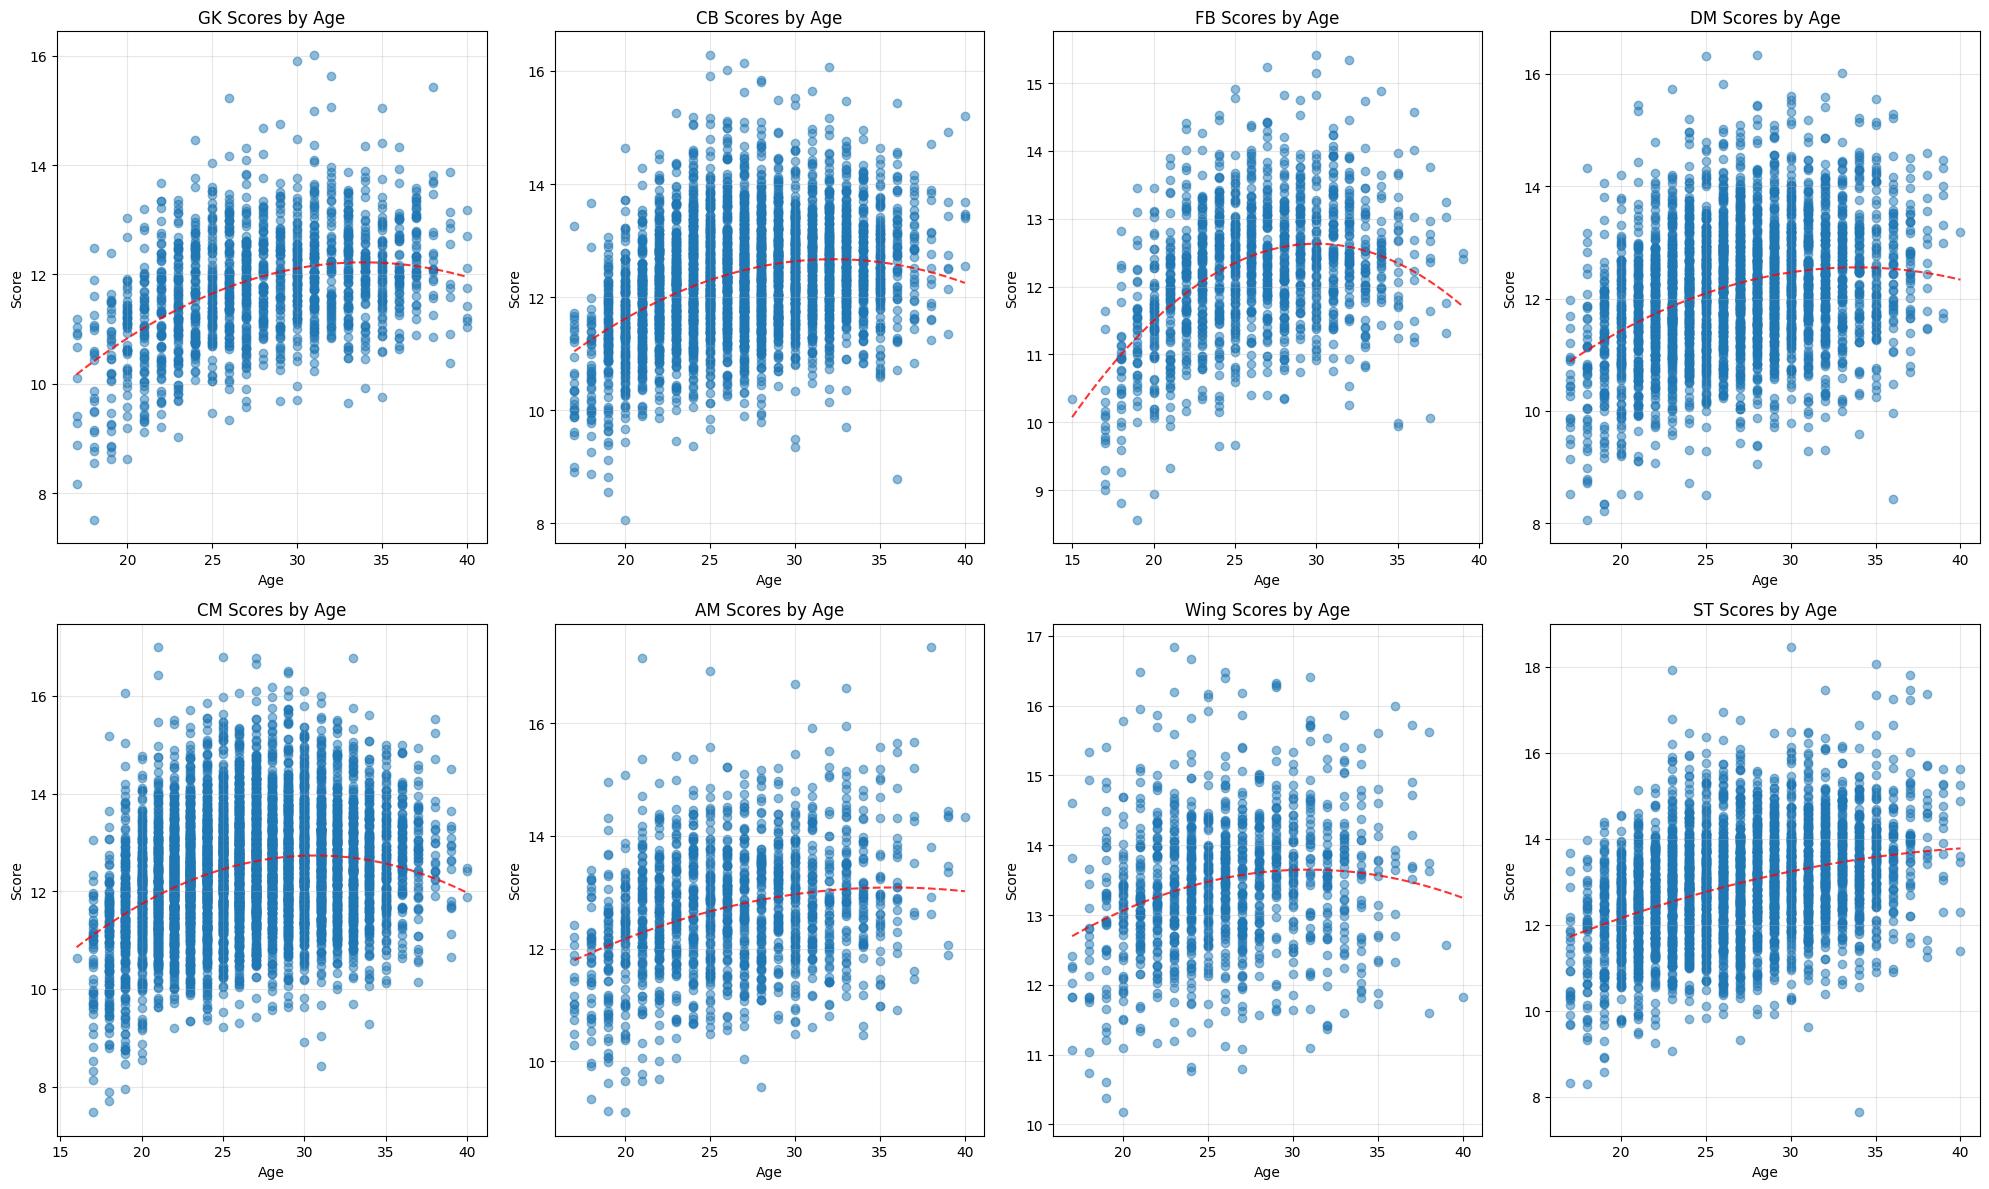

In [8]:
#Remove outliers over 40
score_df = score_df[score_df["age"] <= 40]

def get_max_position_scores(score_df):
    # Define position groups and their corresponding score columns and their boolean columns
    position_groups = {
        'GK': {'roles': ['gk'], 'position_code': 'gk'},
        'CB': {'roles': ['ccb', 'lcb', 'rcb'], 'position_code': 'dc'},
        'FB': {'roles': ['lb', 'rb'], 'position_codes': ['lb', 'rb']},  # Special case for FB
        'DM': {'roles': ['dm'], 'position_code': 'dm'},
        'CM': {'roles': ['cm'], 'position_code': 'mc'},
        'AM': {'roles': ['am'], 'position_code': 'amc'},
        'Wing': {'roles': ['lw', 'rw', 'lif', 'rif'], 'position_codes': ['aml', 'amr']},
        'ST': {'roles': ['dlf', 'af', 'ss'], 'position_code': 'st'}
    }
    
    # New DataFrame for results
    results = []
    
    for _, player in score_df.iterrows():
        player_result = {
            'name': player['name'],
            'age': player['age']
        }
        
        # Calculate max score for each position group
        for group_name, group_info in position_groups.items():
            # Get scores for all positions in this group
            scores = [player[pos] for pos in group_info['roles']]
            
            # Handle special cases for FB and Wing that have multiple position codes
            if 'position_codes' in group_info:
                is_natural = any(player[f'is_{code}'] for code in group_info['position_codes'])
            else:
                is_natural = player[f'is_{group_info["position_code"]}']
                
            player_result[f'is_{group_name.lower()}'] = int(is_natural)
            player_result[group_name] = max(scores)
            
        results.append(player_result)
    
    return pd.DataFrame(results)

def plot_position_age_curves(grouped_df):
    import matplotlib.pyplot as plt
    
    position_groups = ['GK', 'CB', 'FB', 'DM', 'CM', 'AM', 'Wing', 'ST']
    
    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, pos in enumerate(position_groups):
        ax = axes[idx]
        is_pos = f'is_{pos.lower()}'
        
        # Get natural position players
        natural_players = grouped_df[grouped_df[is_pos] == 1]
        
        # Create scatter plot
        ax.scatter(natural_players['age'], natural_players[pos], 
                  alpha=0.5, label=f'Natural {pos}')
        
        # Add trend line
        if len(natural_players) > 1:
            z = np.polyfit(natural_players['age'], natural_players[pos], 2)
            p = np.poly1d(z)
            x_trend = np.linspace(natural_players['age'].min(), natural_players['age'].max(), 100)
            ax.plot(x_trend, p(x_trend), 'r--', alpha=0.8)
        
        ax.set_title(f'{pos} Scores by Age')
        ax.set_xlabel('Age')
        ax.set_ylabel('Score')
        ax.grid(True, alpha=0.3)
        
    plt.tight_layout()
    return plt

# Use the functions
grouped_scores = get_max_position_scores(score_df)
plt = plot_position_age_curves(grouped_scores)
plt.show()

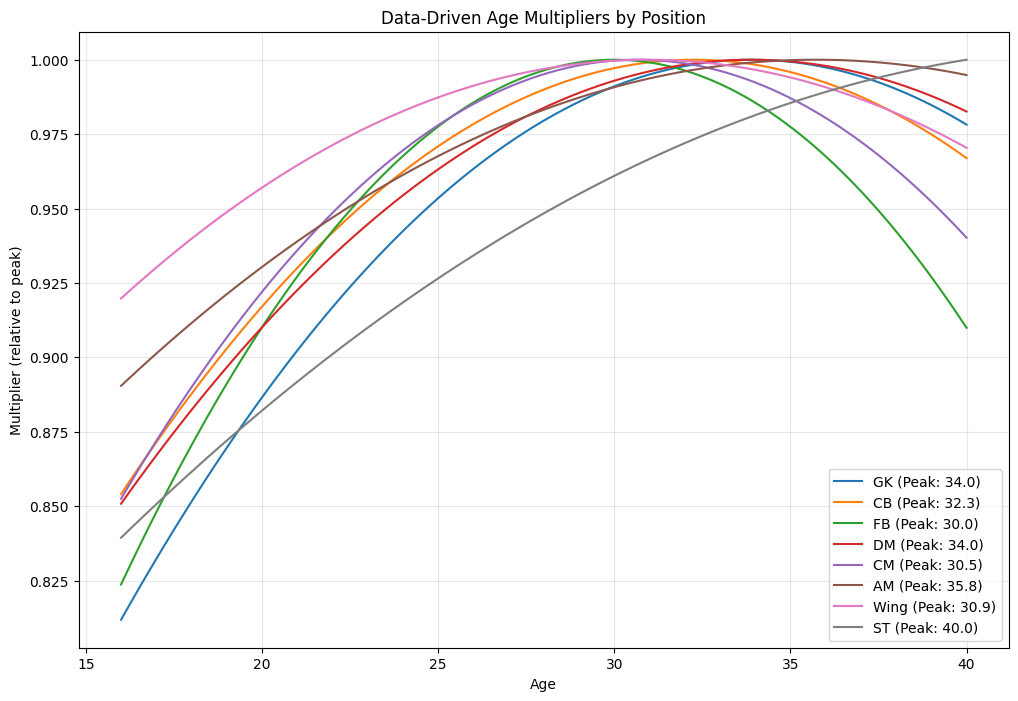

In [16]:
def calculate_data_driven_multipliers(grouped_df):
    """Calculate multipliers based on the actual performance curves from our data"""
    position_groups = ['GK', 'CB', 'FB', 'DM', 'CM', 'AM', 'Wing', 'ST']
    
    multiplier_curves = {}
    
    for pos in position_groups:
        # Get natural position players
        natural_players = grouped_df[grouped_df[f'is_{pos.lower()}'] == 1]
        
        if len(natural_players) > 1:
            # Fit polynomial to get the trend
            z = np.polyfit(natural_players['age'], natural_players[pos], 2)
            p = np.poly1d(z)
            
            # Find peak age and value
            x_range = np.linspace(natural_players['age'].min(), natural_players['age'].max(), 100)
            y_values = p(x_range)
            peak_idx = np.argmax(y_values)
            peak_age = x_range[peak_idx]
            peak_value = y_values[peak_idx]
            
            multiplier_curves[pos] = {
                'curve': p,
                'peak_age': peak_age,
                'peak_value': peak_value
            }
    
    return multiplier_curves

def apply_data_driven_modifiers(df, multiplier_curves):
    """Apply multipliers based on actual performance curves"""
    modified_df = df.copy()
    
    for pos, curve_info in multiplier_curves.items():
        natural_mask = modified_df[f'is_{pos.lower()}'] == 1
        
        for idx in modified_df[natural_mask].index:
            age = modified_df.loc[idx, 'age']
            
            # Calculate expected value at this age
            expected_value = curve_info['curve'](age)
            
            # Calculate multiplier relative to peak
            multiplier = expected_value / curve_info['peak_value']
            
            # Store both the adjusted score and the multiplier
            modified_df.loc[idx, f'{pos}_adjusted'] = modified_df.loc[idx, pos] * multiplier
            modified_df.loc[idx, f'{pos}_multiplier'] = multiplier
    
    return modified_df

# Calculate multipliers from our data
multiplier_curves = calculate_data_driven_multipliers(grouped_scores)

# Apply the data-driven multipliers
adjusted_scores = apply_data_driven_modifiers(grouped_scores, multiplier_curves)

# Visualize the multiplier curves
def plot_data_driven_multipliers(multiplier_curves):
    plt.figure(figsize=(12, 8))
    
    for pos, curve_info in multiplier_curves.items():
        ages = np.linspace(16, 40, 100)
        multipliers = curve_info['curve'](ages) / curve_info['peak_value']
        plt.plot(ages, multipliers, label=f'{pos} (Peak: {curve_info["peak_age"]:.1f})')
    
    plt.title('Data-Driven Age Multipliers by Position')
    plt.xlabel('Age')
    plt.ylabel('Multiplier (relative to peak)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_data_driven_multipliers(multiplier_curves)

In [19]:
benchmark_ages = [18, 20, 22, 24, 26, 28, 30, 32]

# Get multipliers for each position at benchmark ages
benchmark_multipliers = {}

for pos, curve_info in multiplier_curves.items():
   multipliers = []
   for age in benchmark_ages:
       expected_value = curve_info['curve'](age)
       multiplier = expected_value / curve_info['peak_value']
       multipliers.append(round(multiplier, 2))
   benchmark_multipliers[pos] = multipliers

# Convert to DataFrame for clearer display
multiplier_df = pd.DataFrame(benchmark_multipliers, index=benchmark_ages)
print("\nMultipliers by Age and Position:")
print(multiplier_df)

# Also show peak ages for reference
print("\nPeak Ages by Position:")
for pos, info in multiplier_curves.items():
   print(f"{pos}: {info['peak_age']:.1f}")


Multipliers by Age and Position:
      GK    CB    FB    DM    CM    AM  Wing    ST
18  0.85  0.89  0.87  0.88  0.89  0.91  0.94  0.86
20  0.89  0.92  0.91  0.91  0.92  0.93  0.96  0.88
22  0.92  0.94  0.94  0.93  0.95  0.95  0.97  0.90
24  0.94  0.96  0.97  0.95  0.97  0.96  0.98  0.92
26  0.96  0.98  0.99  0.97  0.99  0.97  0.99  0.93
28  0.98  0.99  1.00  0.98  1.00  0.98  1.00  0.95
30  0.99  1.00  1.00  0.99  1.00  0.99  1.00  0.96
32  1.00  1.00  1.00  1.00  1.00  1.00  1.00  0.97

Peak Ages by Position:
GK: 34.0
CB: 32.3
FB: 30.0
DM: 34.0
CM: 30.5
AM: 35.8
Wing: 30.9
ST: 40.0
